In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm

from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.plot import plot_grids
from torchlake.image_generation.models import Vae, VaeLoss

# Setting

In [ ]:
IMAGE_SIZE = 28
BATCH_SIZE = 32

In [ ]:
artifact_path = Path("../data/vae")
data_path = Path("../data/mnist")

In [ ]:
device = torch.device("cuda:0")

# Data

In [ ]:
preprocess = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
    ]
)

In [2]:
train_data = torchvision.datasets.MNIST(
    root=data_path.as_posix(),
    transform=preprocess,
)

In [3]:
train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
)

# model

In [59]:
model = Vae(
    image_size=28 * 28,
    hidden_dim=256,
    latent_dim=64,
).to(device)

In [60]:
criterion = VaeLoss(kld_weight=1)
optimizer = torch.optim.Adam(model.parameters())

In [61]:
epoches = 15

In [62]:
training_loss = []

model.train()
for epoch in range(epoches):
    for img, _ in tqdm(train_loader):
        optimizer.zero_grad()

        img = img.to(device)
        img_flatten = img.view(BATCH_SIZE, -1)

        output, mu, logsigma = model(img)

        loss = criterion(output, img_flatten, mu, logsigma)

        loss.backward()
        optimizer.step()

    print(f"epoch {epoch+1}: {loss/len(train_data)}")
    training_loss.append(loss / len(train_data))

  0%|                                                                                         | 0/1875 [00:00<?, ?it/s]

epoch 1: 0.017231404781341553


  0%|                                                                                         | 0/1875 [00:00<?, ?it/s]

epoch 2: 0.01740696094930172


  0%|                                                                                         | 0/1875 [00:00<?, ?it/s]

epoch 3: 0.01827164925634861


  0%|                                                                                         | 0/1875 [00:00<?, ?it/s]

epoch 4: 0.018575383350253105


  0%|                                                                                         | 0/1875 [00:00<?, ?it/s]

epoch 5: 0.018440723419189453


  0%|                                                                                         | 0/1875 [00:00<?, ?it/s]

epoch 6: 0.015584963373839855


  0%|                                                                                         | 0/1875 [00:00<?, ?it/s]

epoch 7: 0.01904289983212948


  0%|                                                                                         | 0/1875 [00:00<?, ?it/s]

epoch 8: 0.01754814386367798


  0%|                                                                                         | 0/1875 [00:00<?, ?it/s]

epoch 9: 0.018172496929764748


  0%|                                                                                         | 0/1875 [00:00<?, ?it/s]

epoch 10: 0.016757378354668617


  0%|                                                                                         | 0/1875 [00:00<?, ?it/s]

epoch 11: 0.01791335828602314


  0%|                                                                                         | 0/1875 [00:00<?, ?it/s]

epoch 12: 0.01788243278861046


  0%|                                                                                         | 0/1875 [00:00<?, ?it/s]

epoch 13: 0.017521871253848076


  0%|                                                                                         | 0/1875 [00:00<?, ?it/s]

epoch 14: 0.016650710254907608


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:23<00:00, 78.82it/s]

epoch 15: 0.016227474436163902


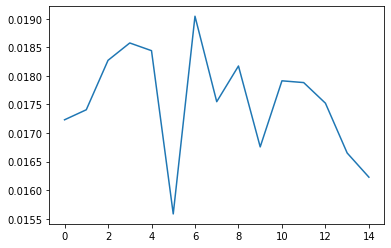

In [63]:
plt.plot(training_loss)

In [ ]:
def generate_gaussian_noise(batch_size: int, latent_dim: int) -> torch.Tensor:
    noise = torch.empty((batch_size, latent_dim)).to(device).normal_(0, 1)
    
    return noise

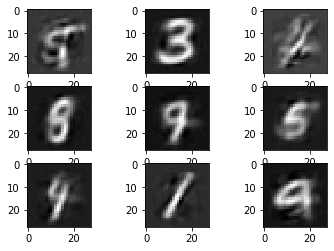

In [78]:
# 合成圖片

model.eval()
with torch.no_grad():
    noise = generate_gaussian_noise(9, 64)
    gen_img = model(noise)
    
    plot_grids(
        img_tensor_to_np(gen_img),
        nrow=3,
        ncol=3,
        is_gray_scale=True,
    )

In [ ]:
model_path = artifact_path / 'vae.pth'

In [12]:
torch.save(model.state_dict(), model_path)

In [ ]:
model.load_state_dict(torch.load(model_path))